In [1]:
from torch import nn
import torch.nn.functional as F
from utils import MetricsCB, DeviceCB, ProgressCB, set_seed, append_stats, conv
from datasets import load_dataset
from torcheval.metrics import MulticlassAccuracy
from dataloaders import DataLoaders
from learners import TrainLearner
from hooks import ActivationStats
from transforms import transformi
import fastcore.all as fc
from functools import partial

set_seed(1)

/Users/dimitarruskov/miniconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/dimitarruskov/miniconda3/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /Users/dimitarruskov/miniconda3/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <DB251723-D0A7-3D18-91AD-79131BDBDDBC> /Users/dimitarruskov/miniconda3/lib/python3.11/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


0.1
0.1
0.1
0.1


accuracy,loss,epoch,train
0.804,0.694,0,train
0.809,0.577,0,eval
0.863,0.439,1,train
0.847,0.467,1,eval
0.880,0.374,2,train
0.867,0.397,2,eval
0.887,0.342,3,train
0.868,0.389,3,eval
0.893,0.318,4,train
0.870,0.374,4,eval


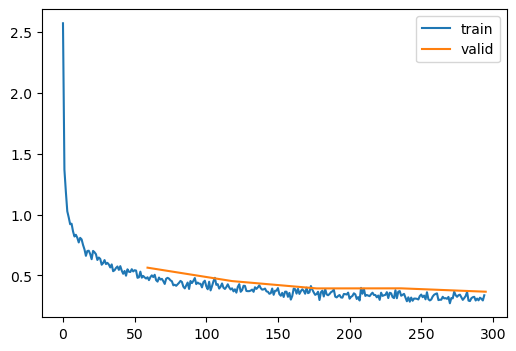

In [5]:


x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)
bs = 1024
def_device='cpu'

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

def get_model(act=partial(nn.ReLU, leak=0.1, sub=0.4), norm=nn.BatchNorm2d, nfs=None, nout=10):
    if nfs is None: nfs = [1, 8, 16, 32, 64]

    layers = [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    layers.append(conv(nfs[-1], nout, act=None))
    layers.append(nn.Flatten())

    return nn.Sequential(*layers).to(def_device)

def fit(model, epochs=1, xtra_cbs=[]):
    cbs = [DeviceCB(), MetricsCB(accuracy=MulticlassAccuracy()), ProgressCB(plot=True)]
    learn = TrainLearner(model, dls, loss_func=F.cross_entropy, lr=0.2, cbs=cbs+list(xtra_cbs))
    learn.fit(epochs)

astats = ActivationStats(append_stats, mod_filter=fc.risinstance(nn.Conv2d))

fit(get_model(), xtra_cbs=[astats], epochs=5)

# General ReLU

The first layer dead neurons are dropping by 25%
Overall performance for 5 epochs is worse than ReLU

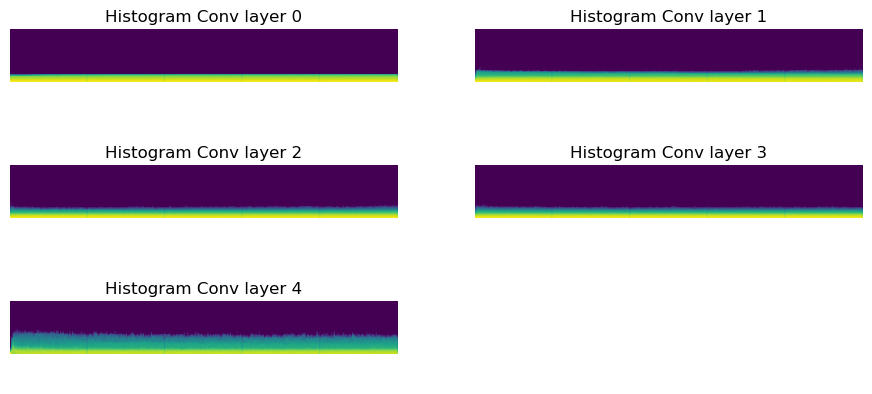

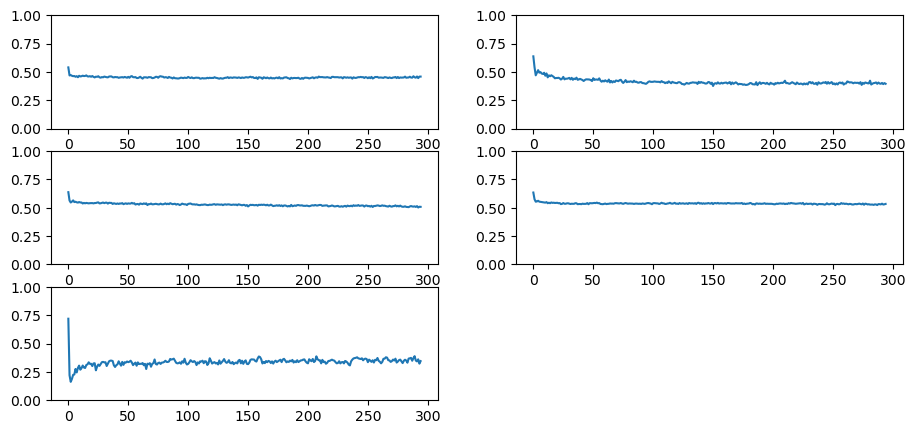

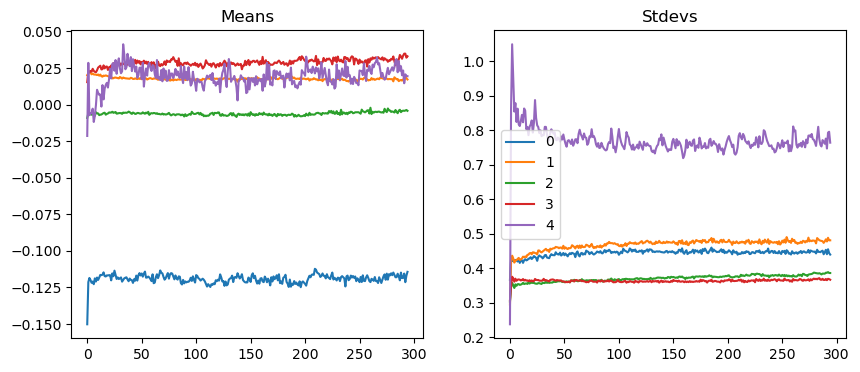

In [6]:
astats.color_dim()
astats.dead_chart()
astats.plot_stats()

# Swish LU

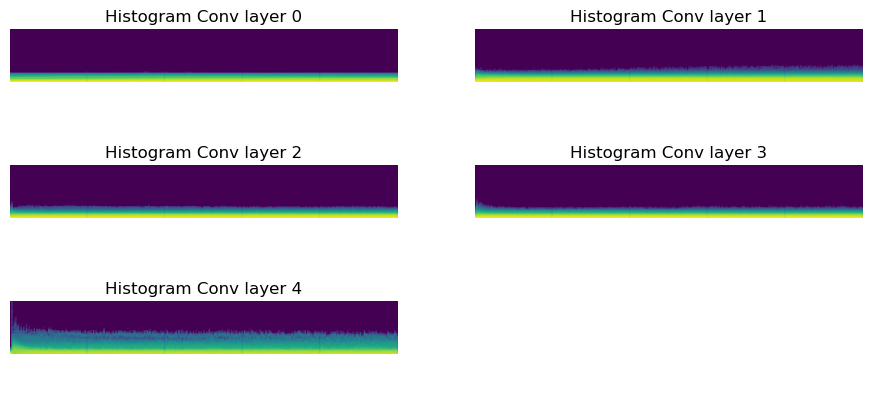

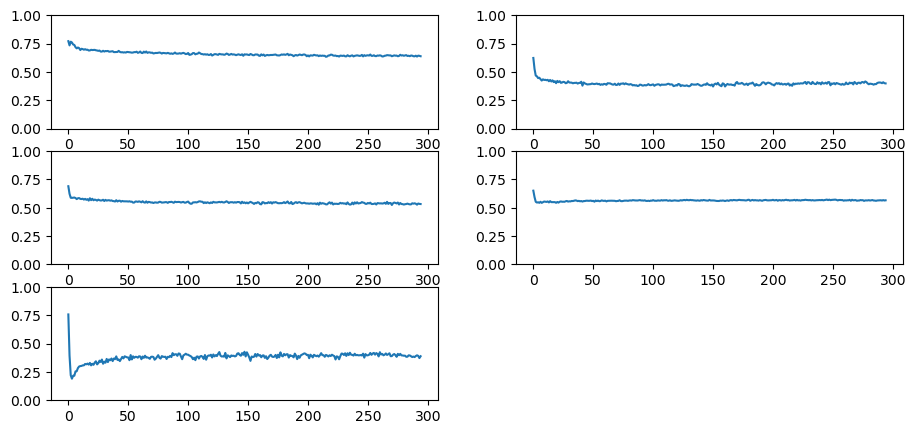

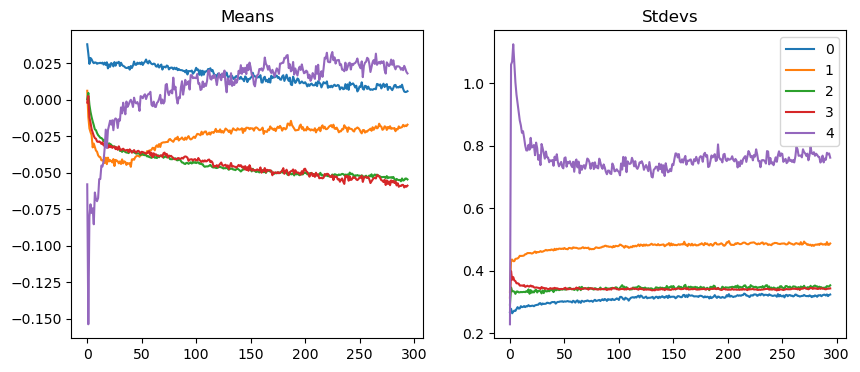

In [10]:
astats.color_dim()
astats.dead_chart()
astats.plot_stats()

# Random Relu

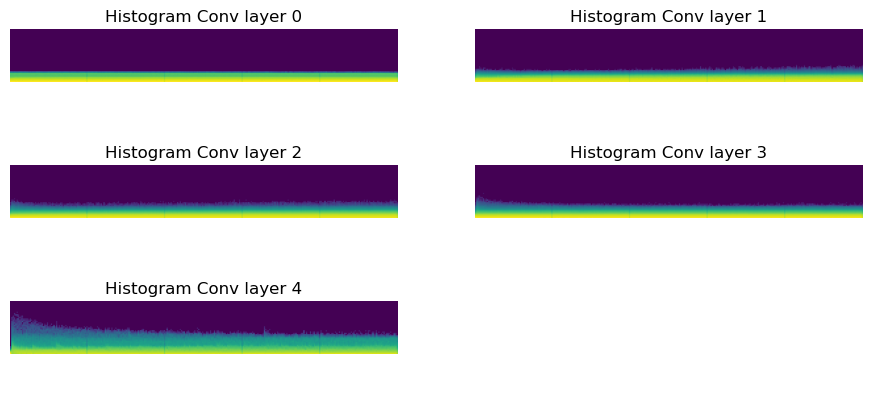

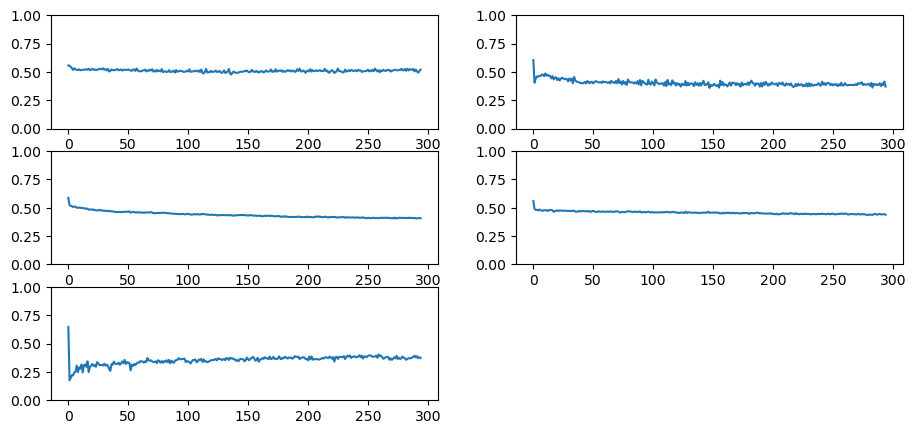

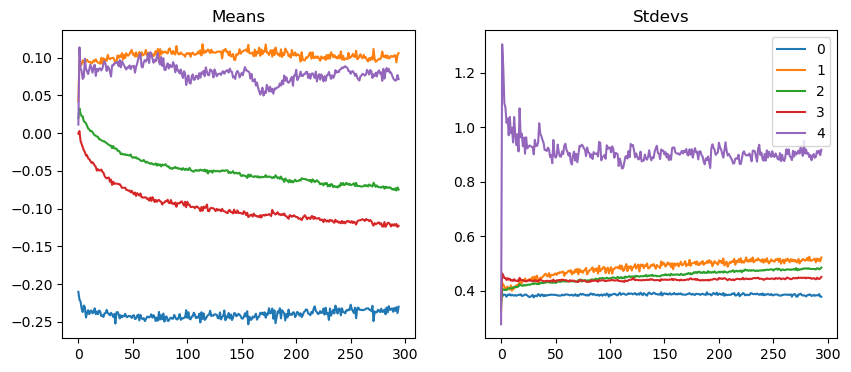

In [8]:
astats.color_dim()
astats.dead_chart()
astats.plot_stats()

# Leaky Relu

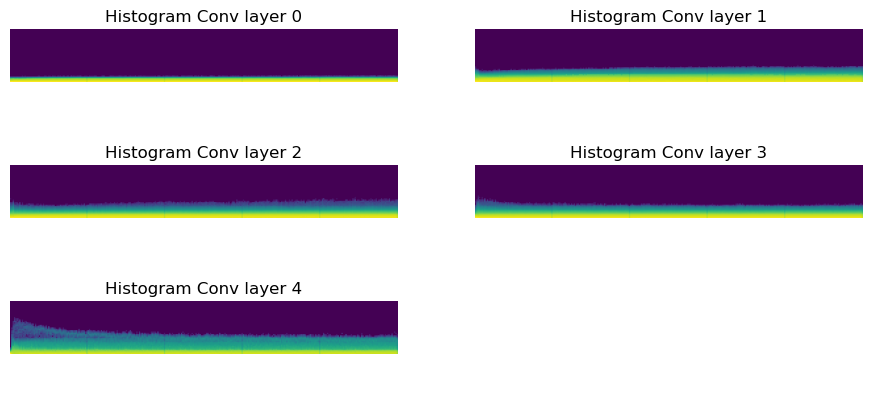

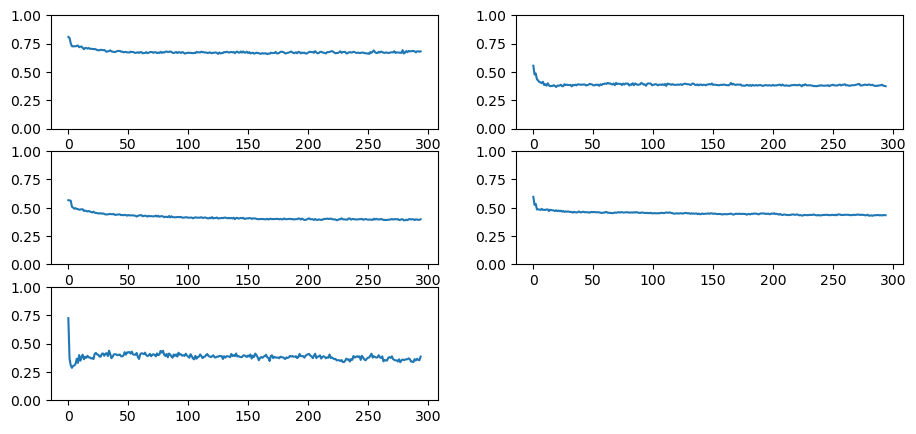

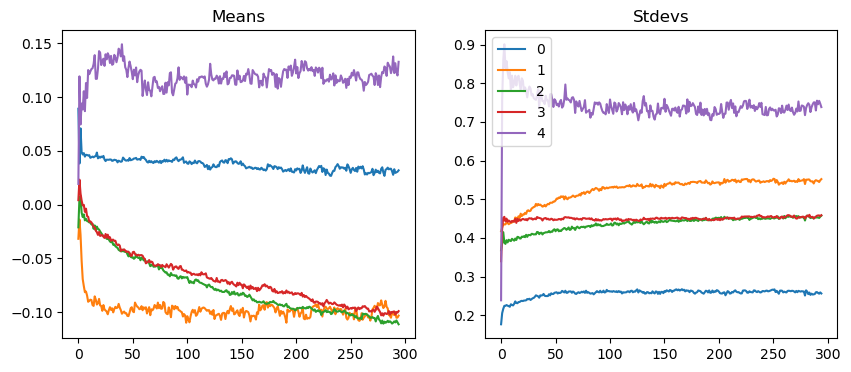

In [6]:
astats.color_dim()
astats.dead_chart()
astats.plot_stats()

# Batch Norm

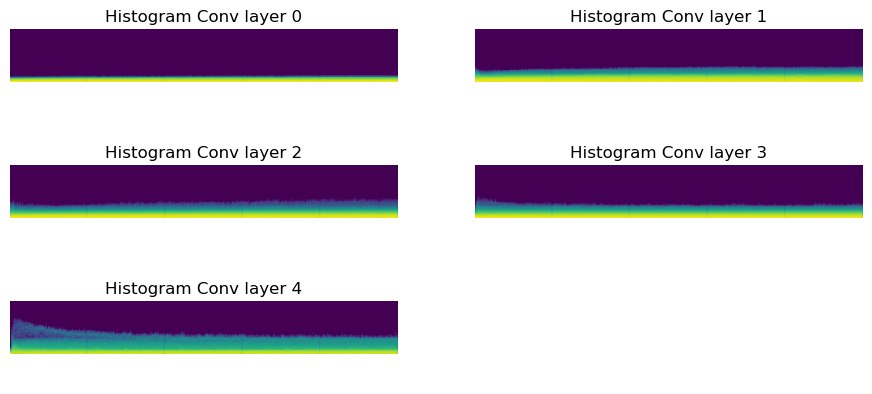

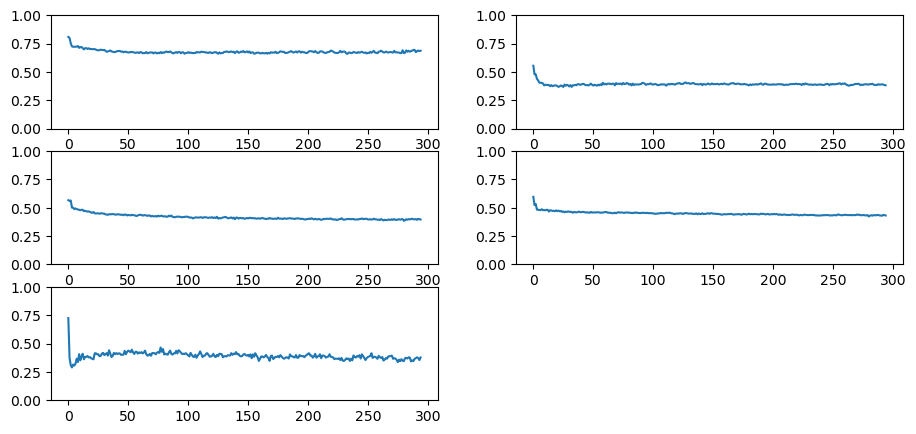

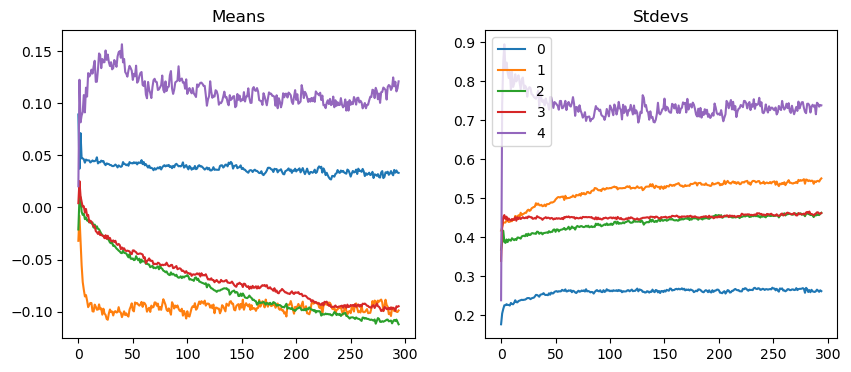

In [3]:
astats.color_dim()
astats.dead_chart()
astats.plot_stats()